In [28]:
# Modelling data
# Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv("df_1.csv", sep=",")
df

,SAPS-I,Creatinine_last_log,BUN_last_log,SOFA,Age,Na_last,SysABP_last,MechVentStartTime,Height,DiasABP_diff,...,Temp_diff,Platelets_diff,WBC_diff,pH_diff,In-hospital_death,CCU,CSRU,SICU,Gender,MechVentLast8Hour
0,0.300668,0.333993,0.085820,0.391428,0.654019,-0.902033,-0.998083,-0.564428,3.472704e-03,1.106864,...,-1.224749,0.096652,-1.120432,1.361086,0,0,1,0,1.0,0.0
1,1.122315,-1.948867,-2.668222,1.101179,-1.176765,-0.204228,0.157873,0.850332,1.881342e-16,0.736089,...,0.893538,-1.162852,-0.449104,0.862658,0,0,0,0,0.0,1.0
2,-0.027991,-0.629755,-0.299047,1.101179,-0.032525,-0.669431,-1.601191,0.010804,3.656963e-02,0.958554,...,-0.885824,1.428128,1.737015,-1.754085,0,1,0,0,1.0,1.0
3,0.793656,-0.869744,1.523650,0.391428,0.768443,-0.436830,0.157873,2.075940,-8.059348e-02,1.032709,...,1.571390,-0.623065,-1.378635,0.738051,1,0,0,0,0.0,1.0
4,-0.027991,0.333993,0.151660,-0.081740,0.539595,0.028374,0.559945,-0.600704,3.472704e-03,-0.747011,...,-1.817870,-0.713030,-0.586812,0.488838,0,0,1,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3736,0.300668,0.209379,-0.299047,0.864595,0.882867,0.028374,1.816419,-0.271630,2.002117e-02,-1.191942,...,0.300417,-0.677044,0.824698,-0.632623,0,0,1,0,1.0,0.0
3737,0.793656,-0.869744,-1.113358,-0.081740,-0.719069,0.260976,-0.596011,-0.131708,1.881342e-16,0.661934,...,-0.801092,0.150630,0.411573,-0.009589,1,0,0,1,1.0,1.0
3738,-0.356650,1.528490,1.727806,0.628011,0.425171,1.191382,-0.093422,-0.261265,1.881342e-16,0.291159,...,0.808806,-0.641058,-0.638453,-1.131051,0,1,0,0,0.0,0.0
3739,0.629327,-0.074468,0.332582,1.101179,-0.719069,-1.134635,-1.651450,-0.489285,5.378003e-02,0.365314,...,1.063001,-0.389157,-0.569599,-0.383410,1,0,0,0,1.0,1.0


In [29]:
print(df['In-hospital_death'].value_counts())

0    3150
1     591
Name: In-hospital_death, dtype: int64


In [30]:
#Downsampling
# separare in righe per target
t0=df[df['In-hospital_death']==0]
t1=df[df['In-hospital_death']==1]
print("t0 e t1: ", len(t0), len(t1))

t0 e t1:  3150 591


In [31]:
from sklearn.utils import resample
t0_down = resample(t0, replace=True, n_samples=1409, random_state=123)
print("t0 down: ", len(t0_down))

t0 down:  1409


In [32]:
df = pd.concat([t0_down, t1])
df

,SAPS-I,Creatinine_last_log,BUN_last_log,SOFA,Age,Na_last,SysABP_last,MechVentStartTime,Height,DiasABP_diff,...,Temp_diff,Platelets_diff,WBC_diff,pH_diff,In-hospital_death,CCU,CSRU,SICU,Gender,MechVentLast8Hour
1604,-0.685309,-0.629755,-1.280057,-0.081740,-0.490221,-0.204228,7.142229e-16,-0.502241,3.472704e-03,0.000000,...,0.130954,-0.389157,0.118943,0.613445,0,0,0,1,1.0,1.0
1342,0.136339,-0.421867,-1.469043,-0.318323,-2.664278,-0.204228,1.012276e+00,-0.574793,5.378003e-02,-0.005461,...,-0.292703,0.438517,0.118943,-0.009589,0,0,0,1,1.0,1.0
2099,0.957986,0.073916,0.151660,1.101179,0.196323,0.493577,1.163053e+00,-0.541108,3.472704e-03,-0.153771,...,-0.038509,0.312567,-0.311396,0.862658,0,0,1,0,1.0,0.0
3658,-0.520979,-0.238498,-0.829350,0.391428,-0.719069,0.493577,-7.467882e-01,-0.302723,-8.919868e-02,-0.450391,...,0.639343,-0.569086,-0.070406,0.115017,0,0,1,0,0.0,0.0
2553,1.450974,-1.500990,-1.687212,1.574346,-2.378218,1.656586,-7.970471e-01,-0.512606,1.881342e-16,-0.524546,...,2.503436,-0.677044,-0.483531,0.987265,0,0,0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,1.450974,0.209379,1.662972,1.574346,0.196323,0.493577,-1.048342e+00,-0.284586,5.378003e-02,-0.450391,...,0.215686,2.237809,0.015661,-1.754085,1,1,0,0,1.0,1.0
3729,-0.192320,0.073916,1.618038,1.574346,0.940079,0.958781,-1.098601e+00,-0.535926,1.881342e-16,0.291159,...,0.808806,-0.335178,0.205010,-0.881837,1,0,0,0,0.0,1.0
3731,0.300668,0.924799,1.132670,1.101179,1.454988,0.260976,-9.478240e-01,-0.647345,-1.984185e-01,-0.227926,...,-0.970555,0.510489,0.945192,0.239624,1,0,1,0,0.0,1.0
3737,0.793656,-0.869744,-1.113358,-0.081740,-0.719069,0.260976,-5.960113e-01,-0.131708,1.881342e-16,0.661934,...,-0.801092,0.150630,0.411573,-0.009589,1,0,0,1,1.0,1.0


In [33]:
# Train test split

#TROVARE MODO DI PESARE IL TARGET

from sklearn.model_selection import train_test_split
y=df['In-hospital_death']
x= df.drop(['In-hospital_death'], axis=1)
X_train, X_test, y_train, y_test=train_test_split(x, y, test_size=0.3, stratify=y, random_state=123)

print(X_train.shape, X_test.shape)
type(y_train)

(1400, 31) (600, 31)


pandas.core.series.Series

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import numpy as np

In [35]:
def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)

    print("f1_test: ", f1_score(y_test, y_pred), "\n\n")
    print(confusion_matrix(y_test, y_pred), "\n\n")
    print(classification_report(y_test, y_pred), "\n\n")

    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()

In [36]:
def roc(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test)

    fpr, tpr, thresholds1 = metrics.roc_curve(y_test, y_probs[:, 1])

    import matplotlib.pyplot as plt
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    auc = metrics.roc_auc_score(y_test, y_probs[:, 1])
    print('AUC: %.2f' % auc)
    return (fpr, tpr)

In [37]:
from sklearn.metrics import average_precision_score, precision_recall_curve

def roc_prec_rec(model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_probs = model.predict_proba(X_test)

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    from sklearn.metrics import auc

    auc_precision_recall = auc(recall, precision)
    print(auc_precision_recall)

f1_train: 0.261334 using {'n_neighbors': 10}
f1_test:  0.22966507177033496 


[[415   8]
 [153  24]] 


              precision    recall  f1-score   support

           0       0.73      0.98      0.84       423
           1       0.75      0.14      0.23       177

    accuracy                           0.73       600
   macro avg       0.74      0.56      0.53       600
weighted avg       0.74      0.73      0.66       600
 




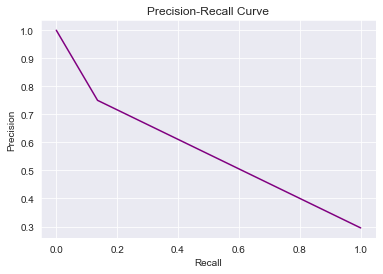

In [38]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(10,100, 1000)}
hyperp_search(classifier,parameters)

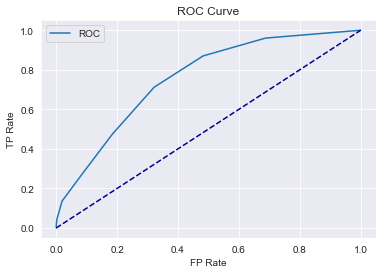

AUC: 0.75
0.5702966101694915


In [39]:
model_knn = KNeighborsClassifier(n_neighbors=10)

fpr1, tpr1 = roc(model_knn, X_train, y_train, X_test, y_test)
roc_prec_rec(model_knn, X_train, y_train, X_test, y_test)

f1_train: 0.580527 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 20}
f1_test:  0.6172344689378757 


[[255 168]
 [ 23 154]] 


              precision    recall  f1-score   support

           0       0.92      0.60      0.73       423
           1       0.48      0.87      0.62       177

    accuracy                           0.68       600
   macro avg       0.70      0.74      0.67       600
weighted avg       0.79      0.68      0.69       600
 




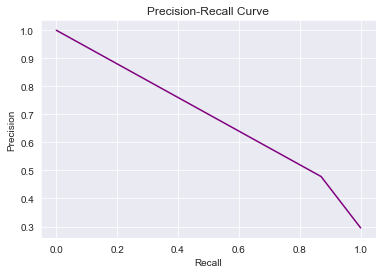

In [40]:
#Tree

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 'max_depth': [4,5,10], 'min_samples_split': [20],'min_samples_leaf': [10], 'class_weight':['balanced']}

hyperp_search(classifier,parameters)

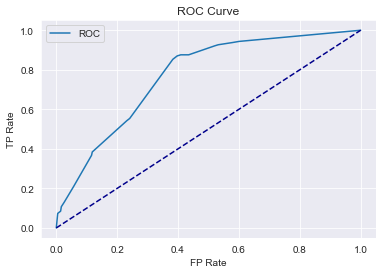

AUC: 0.77
0.6933253500368459


In [41]:
model_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10, min_samples_split=20, class_weight='balanced')

fpr2,tpr2=roc(model_tree,X_train,y_train,X_test,y_test)
roc_prec_rec(model_tree, X_train, y_train, X_test, y_test)

In [42]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB #or alternative NB implementations

model = GaussianNB()

model.fit(X_train, y_train)
y_pred=model.predict(X_test)

from sklearn.metrics import f1_score
print("f1_score: ", f1_score(y_test, y_pred))

print("f1_test: ", f1_score(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1_score:  0.5333333333333333
f1_test:  0.5333333333333333
[[325  98]
 [ 77 100]]
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       423
           1       0.51      0.56      0.53       177

    accuracy                           0.71       600
   macro avg       0.66      0.67      0.66       600
weighted avg       0.72      0.71      0.71       600



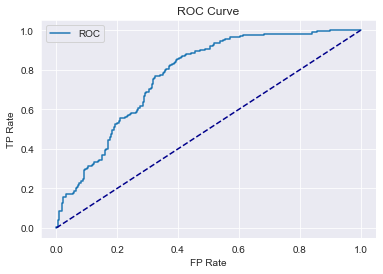

AUC: 0.77
0.5991777948981339


In [43]:
y_probs = model.predict_proba(X_test) #predict_proba gives the probabilities for the target (0 and 1 in your case)

fpr3,tpr3=roc(model,X_train,y_train,X_test,y_test)
roc_prec_rec(model, X_train, y_train, X_test, y_test)

f1_train: 0.623272 using {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}
f1_test:  0.6205250596658711 


[[311 112]
 [ 47 130]] 


              precision    recall  f1-score   support

           0       0.87      0.74      0.80       423
           1       0.54      0.73      0.62       177

    accuracy                           0.73       600
   macro avg       0.70      0.73      0.71       600
weighted avg       0.77      0.73      0.74       600
 




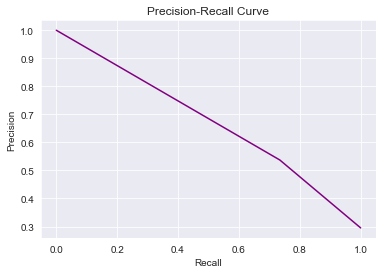

In [44]:
# Logistic

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "max_iter":[1000], 'class_weight':['balanced']}


hyperp_search(classifier,parameters)

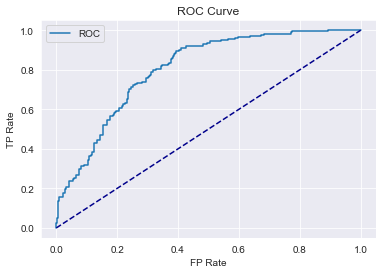

AUC: 0.80
0.6749933464070598


In [45]:
model = LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced')

fpr4,tpr4=roc(model,X_train,y_train,X_test,y_test)
roc_prec_rec(model, X_train, y_train, X_test, y_test)

f1_train: 0.634163 using {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}
f1_test:  0.630071599045346 


[[313 110]
 [ 45 132]] 


              precision    recall  f1-score   support

           0       0.87      0.74      0.80       423
           1       0.55      0.75      0.63       177

    accuracy                           0.74       600
   macro avg       0.71      0.74      0.72       600
weighted avg       0.78      0.74      0.75       600
 




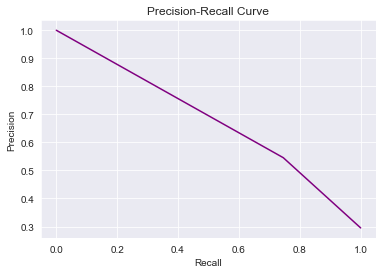

In [46]:
#SVM

from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear', 'rbf'], "C":[0.1, 1], "class_weight":['balanced']}

hyperp_search(classifier,parameters)

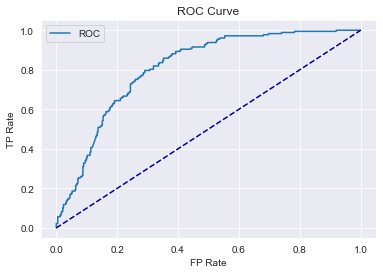

AUC: 0.81
0.6831086286594761


In [47]:
model = SVC(C=1, kernel='rbf',probability=True, class_weight='balanced')

fpr5,tpr5=roc(model,X_train,y_train,X_test,y_test)
roc_prec_rec(model, X_train, y_train, X_test, y_test)

f1_train: 0.587298 using {'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'max_iter': 1000}
f1_test:  0.5243902439024392 


[[358  65]
 [ 91  86]] 


              precision    recall  f1-score   support

           0       0.80      0.85      0.82       423
           1       0.57      0.49      0.52       177

    accuracy                           0.74       600
   macro avg       0.68      0.67      0.67       600
weighted avg       0.73      0.74      0.73       600
 




C:\Users\Alice Donati\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


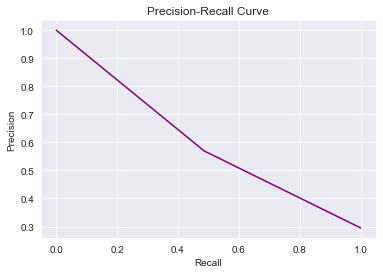

In [48]:
# Multi-layer Perceptron classifier

from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(10, 5),(20,5)],  "max_iter": [1000], "alpha": [0.001,0.1]}

hyperp_search(classifier,parameters)

C:\Users\Alice Donati\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


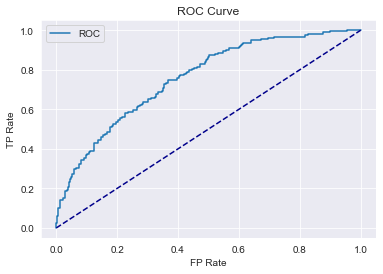

AUC: 0.76
0.6107627118644068


In [49]:
model_MLP=MLPClassifier(hidden_layer_sizes=(10,5), alpha=0.1, max_iter=1000)

fpr6,tpr6=roc(model_MLP,X_train,y_train,X_test,y_test)
roc_prec_rec(model_MLP, X_train, y_train, X_test, y_test)

In [50]:
import numpy as np

from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=50, random_state=123)
parameters={'criterion': ['entropy','gini'], 'max_depth': [4,5,10], 'min_samples_leaf': [5, 10],'min_samples_split': [5, 10], 'class_weight':['balanced']}

def hyperp_search(classifier, parameters):
    gs=GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs=gs.fit(X_train, y_train)
    print("f1_train: %f using %s" %(gs.best_score_, gs.best_params_))

    best_model=gs.best_estimator_
    y_pred=best_model.predict(X_test)

    print("f1_test: ", f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

hyperp_search(classifier,parameters)

f1_train: 0.632777 using {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5}
f1_test:  0.6179245283018868
[[307 116]
 [ 46 131]]
              precision    recall  f1-score   support

           0       0.87      0.73      0.79       423
           1       0.53      0.74      0.62       177

    accuracy                           0.73       600
   macro avg       0.70      0.73      0.70       600
weighted avg       0.77      0.73      0.74       600



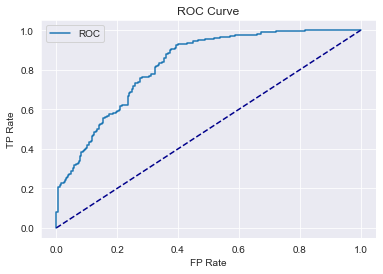

AUC: 0.82
0.6311133266866069


In [51]:
model_RF=RandomForestClassifier(criterion='gini', max_depth=5, min_samples_leaf=10, min_samples_split=5)

fpr7,tpr7=roc(model_RF,X_train,y_train,X_test,y_test)
roc_prec_rec(model_RF, X_train, y_train, X_test, y_test)

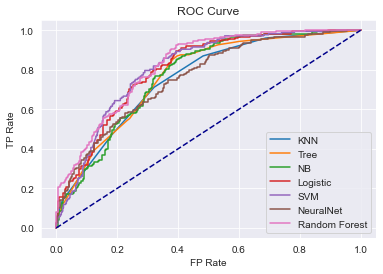

In [52]:
import matplotlib.pyplot as plt
plt.plot(fpr1, tpr1, label= "KNN")
plt.plot(fpr2, tpr2, label= "Tree")
plt.plot(fpr3, tpr3, label= "NB")
plt.plot(fpr4, tpr4, label= "Logistic")
plt.plot(fpr5, tpr5, label= "SVM")
plt.plot(fpr6, tpr6, label= "NeuralNet")
plt.plot(fpr7, tpr7, label= "Random Forest")
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [53]:
## Neural network - ok ma si può migliorare

In [54]:
X_train_tuner, X_val_tuner, y_train_tuner, y_val_tuner = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=123)

print(X_train_tuner.shape, X_val_tuner.shape)
type(y_train)

(980, 31) (420, 31)


pandas.core.series.Series

In [55]:
from keras.utils import to_categorical
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
num_classes=2
y_train_tuner_cat = to_categorical(y_train_tuner, num_classes)
y_val_tuner_cat = to_categorical(y_val_tuner, num_classes)
y_test_cat = to_categorical(y_test, num_classes)
y_train_tuner_cat

ModuleNotFoundError: No module named 'keras_tuner'

In [ ]:
# Sequential model 
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    model = keras.Sequential()
   # model.add(layers.Input(None, 39))
    # model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=128, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(2, activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [ ]:
tuner.search(X_train_tuner, y_train_tuner_cat, epochs=10, validation_data=(X_val_tuner, y_val_tuner_cat))

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 39))
best_model.summary()

In [ ]:
# Fit with the entire dataset.
x_all = np.concatenate((X_train_tuner, X_val_tuner))
y_all = np.concatenate((y_train_tuner_cat, y_val_tuner_cat))

x_all.shape

In [ ]:
# Get the top 2 hyperparameters.

from keras.callbacks import EarlyStopping
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])

#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history= model.fit(x=x_all, y=y_all, validation_split=0.33, epochs=300, batch_size=50, callbacks=[earlystopping])

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
max_y_pred = np.argmax(y_pred, axis=1)
max_y_pred



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy: ", accuracy_score(y_test, max_y_pred))
print("Precision: ", precision_score(y_test,max_y_pred))
print("Recall: ", recall_score(y_test, max_y_pred))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conmat = confusion_matrix(y_test, max_y_pred)
val = np.mat(conmat) 

classnames = ['alive','dead']

df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()    

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, max_y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
